In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import colors
import aplpy
import astropy.wcs as wcs
import imf

In [2]:
### load constants and functions
# Image information and assumptions
distance        = 8340. # distance to GC; Reid et al. 2014
#Temp            = 20.0
Wave            = (3.0e8/(226e9))
Wave0           = 1.3e-3
k0              = 0.899
nu              = 3.e08/Wave
nu0             = 3.e08/Wave0
beta            = 1.75
Kappag2d        = k0*((nu/nu0)**beta)
g2d             = 100.0
Kappa           = Kappag2d / g2d
mu              = 2.8 # express everything in H2

dustTemp = 20

# Constants
G = 6.67408e-11
msun = 1.989e33
mh = 1.6737236e-27
pc2cm = 3.08567758e18
as2persr = 4.25e10 
percm2perm = 1.0e6
JyperSr_to_JyperPix = (3.0462*(10**-4))*((0.00013888888888)**2) ### 
JyperSr_to_Jyperassqr = ((np.pi*180.)**(-2))*(3600**(-1))
hplanck = 6.63e-34
clight = 2.99792e8
kboltzmann = 1.381e-23
sin1yr = 3.15569e7
arcsec2pc = distance/((360./(2.*np.pi))*60.*60.)

In [3]:
def planck_wave( Wave, Temp ):

    # Planck function using wavelength

    planck_conv_wave = 1.e-26 * clight / Wave**2.0

    planck = ((2.0*hplanck*clight**2.0)/(Wave**5.0))*(1.0/(np.exp((hplanck*clight)/(Wave*kboltzmann*Temp))-1.0))
    planck = planck/planck_conv_wave

    return planck

def mass_calc_submm( Wave, Temp, Kappa, Integrated_Flux, Obj_Dist ):

    Obj_Dist = Obj_Dist * pc2cm
    #from planck_func import planck_wave
    B = planck_wave( Wave, Temp )
    Mass = (Obj_Dist**2. * Integrated_Flux) / ( Kappa * B )
    Mass = Mass / msun
    return Mass

In [4]:
### flux to mass for point source for simulated observation source recovery tests
### FOR JY/BEAM POINT SOURCES
### OR JY/PIX POINT SOURCES
point_flux = 0.15 ### jy/beam
#BMAJ    =   9.391762150659E-04                                                  
#BMIN    =   8.101911677255E-04
BMAJ    =   9.207714266247E-04                                                  
BMIN    =   6.383301814397E-04 
deg2_per_beam = np.pi*BMAJ*BMIN
deg2_per_pix = (1.388888888889E-04)**2
print(deg2_per_beam/deg2_per_pix)
#flux_integrated = point_flux*(deg2_per_pix/deg2_per_beam)
#print flux_integrated
#mass = mass_calc_submm(Wave,dustTemp,Kappa,flux_integrated,distance)

point_flux_jy_per_pix = point_flux * (deg2_per_pix/deg2_per_beam)
print(point_flux_jy_per_pix)
point_flux_jy_per_pix = 0.05
mass = mass_calc_submm(Wave,50,Kappa,point_flux_jy_per_pix,distance)

print(mass)


95.72206929962044
0.0015670367460453008
27.36849660071255


In [5]:
### NOISE CONVERSION FROM CATALOG VALUE TO SIMOBS VALUE
BMAJ    =   9.207714266247E-04                                                  
BMIN    =   6.383301814397E-04 
deg2_per_beam = np.pi*BMAJ*BMIN
deg2_per_pix = (1.388888888889E-04)**2
#print deg2_per_beam/deg2_per_pix
deg2_per_sr = 3282.8
noise_jy_per_sr = 4.0e6
noise_jy_per_beam = noise_jy_per_sr*(deg2_per_beam/deg2_per_sr)
noise_jy_per_pix = noise_jy_per_sr*(deg2_per_pix/deg2_per_sr)
print noise_jy_per_pix
print noise_jy_per_beam

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(noise_jy_per_pix)? (<ipython-input-5-d96afafdc606>, line 11)

In [8]:
### Plot for mass vs percent found
### also average runs together

path = '/Users/hph/cmzoom_catalog/simobserve_acc/'

BMAJ    =   9.391762150659E-04
BMIN    =   8.101911677255E-04 
deg2_per_beam = np.pi*BMAJ*BMIN
deg2_per_pix = (1.388888888889E-04)**2


found_avg = np.array([1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    0.98,  0.98,  0.94,  0.94,
                      0.9,   0.9,   0.82,  0.68,  0.58,  0.4,   0.34,  0.28,  0.1,   0.08,  0.,    0.,    0.,
                      0.,    0.,    0.,    0.,    0.,    0.  ])

hightau_avg = np.array([0.98,  0.98,  0.98,  0.96,  0.96,  0.96,  0.96,  0.96,  0.96,  0.92,  0.92,  0.88,
                        0.84,  0.82,  0.7,   0.66,  0.54,  0.48,  0.36,  0.32,  0.22,  0.1,   0.1,   0.08,
                        0.02,  0.02,  0.,    0.,    0.,    0.,    0.])

point_fluxes = np.array([0.08,        0.07733667,  0.07467333,  0.07201,     0.06934667,  0.06668333,
                         0.06402,     0.06135667,  0.05869333,  0.05603,     0.05336667,  0.05070333,
                         0.04804,     0.04537667,  0.04271333,  0.04005,     0.03738667,  0.03472333,
                         0.03206,     0.02939667,  0.02673333,  0.02407,     0.02140667,  0.01874333,
                         0.01608,     0.01341667,  0.01075333,  0.00809,     0.00542667,  0.00276333,
                         0.0001    ])
#fp_avg = np.array([1.4,  1.4,  1.4,  1.2,  0.8,  1.,   2.,   1.2,  0.8,  0.6,  0.2,  0.2,  0.2,  0.2,  0.,
#                     0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
#                     0. ])
fp_avg = np.array([ 1.,   0.6, 0.8,  1.,   0.6,  0.2,  0.4,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.,
                    0.,   0.,   0.2 , 0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
                    0. ])
fp_avg = fp_avg/10.
#integrated_fluxes = point_fluxes*(deg2_per_pix/deg2_per_beam)
integrated_fluxes = point_fluxes
masses = mass_calc_submm(Wave,dustTemp,Kappa,integrated_fluxes,distance)


plt.close()
mrfig = plt.figure(3,figsize=(5,5))
mrfig.clf()
ax = mrfig.gca()
ax.plot(masses, found_avg,ls='-',color='tomato',linewidth='3.0', label='% Sources Recovered')
ax.plot(masses, hightau_avg,ls='-',color='purple',linewidth='2.0', label ='% Sources Found, high' )
ax.plot(masses, fp_avg,ls='-',color='k',linewidth='3.0',label='% false sources found')
plt.xlabel('Mass of Point Source (Solar Masses)')
plt.ylabel('Percentage Value')
#plt.ylabel('Percent Sources Found')
plt.title('Completeness of Catalog Algorithm for Point Sources')
ax.set_ylim(0,1.05)
ax.set_xlim(0,130.)

ax.grid()
fill = ax.fill_between(masses,found_avg, color='tomato',alpha=0.2,edgecolor='red',linewidth = '0.0')
fill = ax.fill_between(masses,fp_avg, color='k',alpha=0.2,edgecolor='k',linewidth = '0.0')
plt.legend(loc='upper left',fontsize=8)
mrfig.savefig(path+'simobs_percent.pdf',format='pdf')
plt.show()


ValueError: 
\Tau_{0}
^
Unknown symbol: \Tau (at char 0), (line:1, col:1)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x117c32158> (for post_execute):


ValueError: 
\Tau_{0}
^
Unknown symbol: \Tau (at char 0), (line:1, col:1)

ValueError: 
\Tau_{0}
^
Unknown symbol: \Tau (at char 0), (line:1, col:1)

<Figure size 360x360 with 1 Axes>

In [129]:
### aplpy figures for simobs frames
def make_simobs_panel(path,inputfits1,inputfits2,maskfits,label):
    plt.close()
    fg_color='white'
    bg_color='black'
    contour_hdu = fits.open(path+maskfits)[0]

    data_hdu = fits.open(path+inputfits1)[0]
    #data_hdu.data = data_hdu.data[]
    fig = plt.figure(figsize=(15, 5))#,facecolor=bg_color, edgecolor=fg_color)
    print(data_hdu.data.shape)
    subplot1 = aplpy.FITSFigure(path+inputfits1,subplot=[0.1,0.1,0.265,0.8], slices = (2,3), 
                                figure = fig, convention='calabretta') #
    vmin,vmax = -0.001,0.1
    subplot1.show_colorscale(vmin=vmin, vmax=vmax,cmap='inferno')
    #subplot.frame.set_color(fg_color)
    subplot1.set_nan_color(bg_color)
    subplot1.ticks.set_xspacing(0.02)
    subplot1.ticks.set_yspacing(0.02)
    subplot1.ticks.set_color('black')
    subplot1.tick_labels.set_xformat('d.dd')
    subplot1.tick_labels.set_yformat('d.dd')
    #subplot.ticks.set_color(fg_color)
    #subplot.recenter(xcenter, ycenter, width = 50. / 3600., height = 50. / 3600.)
    subplot1.add_label(0.35, 0.95, str(label), relative = True, weight = 'bold', size = 10, color = 'white')
    #subplot.show_markers(xcenter, ycenter, marker = '+', facecolor = 'red', edgecolor = 'red', s = 1000)
    subplot1.show_contour(path+maskfits,slices=(1,2),
                         colors = 'white', levels = [0.0,], linewidths = 0.7,
                         convention = 'calabretta', zorder = 10, linestyle = 'solid')
    subplot1.axis_labels.set_xtext('Galactic Longitude (degrees)')
    subplot1.axis_labels.set_ytext('Galactic Latitude (degrees)')
    subplot1.ticks.show()
    subplot1.add_scalebar(length=24./3600.)
    subplot1.scalebar.set_label('1 pc')
    subplot1.scalebar.set_color('white')
    subplot1.add_colorbar()
    
    subplot2 = aplpy.FITSFigure(path+inputfits2,subplot=[0.55,0.1,0.265,0.8], slices = (2,3), 
                                figure = fig, convention='calabretta')
    
    fits.open(path+inputfits2)[0]
    initial_wcs = wcs.WCS(initial_hdu.header)
    init_cond = np.where(initial_data!=0)
    wcs_init = initial_wcs.wcs_pix2world(init_cond[0],init_cond[1],1)
    transformed_pix = initial_wcs.wcs_world2pix(wcs_init[0],wcs_init[1],1)
    
    vmin,vmax = -0.001,0.1
    subplot2.show_colorscale(vmin=vmin, vmax=vmax,cmap='inferno')
    #subplot.frame.set_color(fg_color)
    subplot2.set_nan_color(bg_color)
    subplot2.ticks.set_xspacing(0.02)
    subplot2.ticks.set_yspacing(0.02)
    subplot2.ticks.set_color('black')
    subplot2.tick_labels.set_xformat('d.dd')
    subplot2.tick_labels.set_yformat('d.dd')
    subplot2.add_label(0.35, 0.95, 'Random Point Souce Map', relative = True, weight = 'bold', size = 10, color = 'white')
    plt.scatter(transformed_pix[1],transformed_pix[0],color='limegreen',marker='x')
    subplot2.show_contour(path+maskfits,slices=(1,2),
                         colors = 'white', levels = [0.0,], linewidths = 0.7,
                         convention = 'calabretta', zorder = 10, linestyle = 'solid')
    subplot2.axis_labels.set_xtext('Galactic Longitude (degrees)')
    subplot2.axis_labels.set_ytext('Galactic Latitude (degrees)')
    subplot2.ticks.show()
    subplot2.add_scalebar(length=24./3600.)
    subplot2.scalebar.set_label('1 pc')
    subplot2.scalebar.set_color('white')
    subplot2.add_colorbar()
    
    plt.plot()
    #subplot.tick_labels.set_font(color=fg_color)
    #subplot.axis_labels.set_font(color=fg_color)
    #subplot.axis_labels.set_color(fg_color)
    #fig.tight_layout()
    fig.savefig(path+'simobs_example.pdf',format='pdf')
    #plt.show()
    

(200, 200)


Set OBSGEO-B to    19.947177 from OBSGEO-[XYZ].
Set OBSGEO-H to     6578.484 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    19.947177 from OBSGEO-[XYZ].
Set OBSGEO-H to     6578.484 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to    19.947177 from OBSGEO-[XYZ].
Set OBSGEO-H to     6578.484 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized ke

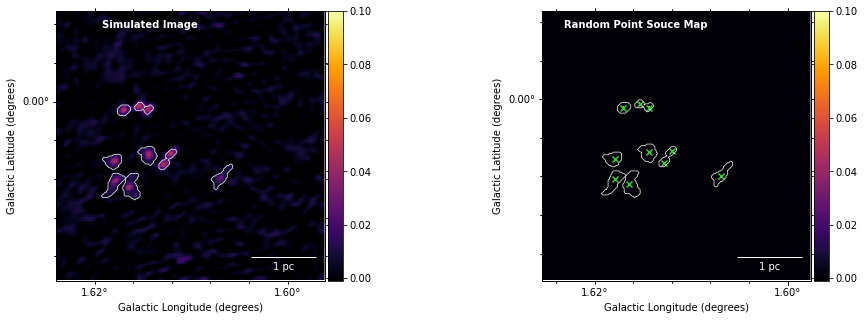

In [130]:
path = '/Users/hph/cmzoom_catalog/simobserve_kernel/'
make_simobs_panel(path,'final_noregrid_image_9-27-19_0.fits','initial_temp_image_9-27-19_0.fits',
                  'temp_mask_9-27-19_0.fits','Simulated Image')
plt.show()

In [103]:
mask_hdu=fits.open(path+'temp_mask_9-27-19_0.fits')
wcs.WCS(mask_hdu[0])
#print(mask_hdu[0].header)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-SIN'  'GLAT-SIN'  
CRVAL : 1.61  -0.0045  
CRPIX : 101.0  101.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0001388888888889  0.0001388888888889  
NAXIS : 200  200

In [101]:
def fix_bad_axes(path,filename):
    initial_hdu = fits.open(path+filename)[0]
    print("initial # axes, data shape: ",initial_hdu.header['NAXIS'],initial_hdu.data.shape)
    if initial_hdu.data.shape==(1, 1, 200, 200):
        initial_hdu.data = initial_hdu.data[0,0,:,:]
    for keyval in ['CRVAL3','CRVAL4','CTYPE3','CTYPE4','CDELT3','CDELT4','CUNIT3','CUNIT4','CRPIX3','CRPIX4',
                   'PC03_01','PC03_02','PC03_03','PC03_04','PC04_01','PC04_02',
                   'PC04_03','PC04_04','PC01_03','PC01_04','PC02_03','PC02_04',
                   'PC3_1','PC3_2','PC3_3','PC3_4','PC4_1','PC4_2',
                   'PC4_3','PC4_4','PC1_3','PC1_4','PC2_3','PC2_4']:
        if keyval in list(initial_hdu.header.keys()):
            print('Eliminating '+keyval+'...')
            initial_hdu.header.remove(keyval)
    initial_hdu.header['NAXIS']=2
    fits.writeto(path+filename,data=initial_hdu.data,header=initial_hdu.header,overwrite=True)
    print("initial # axes, data shape: ",initial_hdu.header['NAXIS'],initial_data.shape)
    print(path+filename)

fix_bad_axes(path,'initial_temp_image_9-27-19_0.fits')
fix_bad_axes(path,'final_noregrid_image_9-27-19_0.fits')
fix_bad_axes(path,'temp_mask_9-27-19_0.fits')

initial # axes, data shape:  2 (200, 200)
initial # axes, data shape:  2 (200, 200)
/Users/hph/cmzoom_catalog/simobserve_kernel/initial_temp_image_9-27-19_0.fits
initial # axes, data shape:  2 (200, 200)
initial # axes, data shape:  2 (200, 200)
/Users/hph/cmzoom_catalog/simobserve_kernel/final_noregrid_image_9-27-19_0.fits
initial # axes, data shape:  2 (200, 200)
initial # axes, data shape:  2 (200, 200)
/Users/hph/cmzoom_catalog/simobserve_kernel/temp_mask_9-27-19_0.fits


In [23]:
initial_hdu = fits.open(path+'initial_temp_image_9-27-19_0.fits')[0]
final_hdu = fits.open(path+'final_noregrid_image_9-27-19_0.fits')[0]

def fix_bad_axes(path,filename):
    initial_hdu = fits.open(path+filename)[0]
    initial_data = initial_hdu.data[0,0,:,:]
    initial_hdu.header.remove('CRVAL3')
    initial_hdu.header.remove('CRVAL4')
    initial_hdu.header.remove('CTYPE3')
    initial_hdu.header.remove('CTYPE4')
    initial_hdu.header.remove('CDELT3')
    initial_hdu.header.remove('CDELT4')
    initial_hdu.header.remove('CUNIT3')
    initial_hdu.header.remove('CUNIT4')
    initial_hdu.header.remove('CRPIX3')
    initial_hdu.header.remove('CRPIX4')
    initial_hdu.header.remove('PC03_01')
    initial_hdu.header.remove('PC03_02')
    initial_hdu.header.remove('PC03_03')
    initial_hdu.header.remove('PC03_04')
    initial_hdu.header.remove('PC04_01')
    initial_hdu.header.remove('PC04_02')
    initial_hdu.header.remove('PC04_03')
    initial_hdu.header.remove('PC04_04')
    initial_hdu.header.remove('PC01_03')
    initial_hdu.header.remove('PC01_04')
    initial_hdu.header.remove('PC02_03')
    initial_hdu.header.remove('PC02_04')
    initial_hdu.writeto(path+filename,overwrite=True)
    

initial_data = initial_hdu.data
initial_hdu.header.remove('CRVAL3')
initial_hdu.header.remove('CRVAL4')
initial_hdu.header.remove('CTYPE3')
initial_hdu.header.remove('CTYPE4')
initial_hdu.header.remove('CDELT3')
initial_hdu.header.remove('CDELT4')
initial_hdu.header.remove('CUNIT3')
initial_hdu.header.remove('CUNIT4')
initial_hdu.header.remove('CRPIX3')
initial_hdu.header.remove('CRPIX4')
initial_hdu.header.remove('PC03_01')
initial_hdu.header.remove('PC03_02')
initial_hdu.header.remove('PC03_03')
initial_hdu.header.remove('PC03_04')
initial_hdu.header.remove('PC04_01')
initial_hdu.header.remove('PC04_02')
initial_hdu.header.remove('PC04_03')
initial_hdu.header.remove('PC04_04')
initial_hdu.header.remove('PC01_03')
initial_hdu.header.remove('PC01_04')
initial_hdu.header.remove('PC02_03')
initial_hdu.header.remove('PC02_04')

final_hdu.header.remove('CRVAL3')
final_hdu.header.remove('CRVAL4')
final_hdu.header.remove('CTYPE3')
final_hdu.header.remove('CTYPE4')
final_hdu.header.remove('CDELT3')
final_hdu.header.remove('CDELT4')
final_hdu.header.remove('CUNIT3')
final_hdu.header.remove('CUNIT4')
final_hdu.header.remove('CRPIX3')
final_hdu.header.remove('CRPIX4')
final_hdu.header.remove('PC3_1')
final_hdu.header.remove('PC3_2')
final_hdu.header.remove('PC3_3')
final_hdu.header.remove('PC3_4')
final_hdu.header.remove('PC4_1')
final_hdu.header.remove('PC4_2')
final_hdu.header.remove('PC4_3')
final_hdu.header.remove('PC4_4')
final_hdu.header.remove('PC1_3')
final_hdu.header.remove('PC1_4')
final_hdu.header.remove('PC2_3')
final_hdu.header.remove('PC2_4')
final_hdu.header.remove('NAXIS3')
final_hdu.header.remove('NAXIS4')
final_hdu.header['NAXIS']=2


final_wcs = wcs.WCS(final_hdu)

print(final_hdu.header)
initial_hdu.writeto(path+'initial_temp_image_9-27-19_0.fits',overwrite=True)
final_hdu.writeto(path+'final_noregrid_image_9-27-19_0.fits',overwrite=True)

#print np.where(initial_data!=0)
#initial_wcs = wcs.WCS(initial_hdu.header)
#initial_wcs
#init_cond = np.where(initial_data!=0)
#print initial_wcs
#wcs_init = initial_wcs.wcs_pix2world(init_cond[0],init_cond[1],1)
#print wcs_init
#transformed_pix = initial_wcs.wcs_world2pix(wcs_init[0],wcs_init[1],1)

SIMPLE  =                    T /Standard FITS                                   BITPIX  =                  -32 /Floating point (32 bit)                         NAXIS   =                    2                                                  NAXIS1  =                  200                                                  NAXIS2  =                  200                                                  EXTEND  =                    T                                                  BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 BZERO   =   0.000000000000E+00                                                  BMAJ    =   9.605898459752E-04                                                  BMIN    =   6.667590141296E-04                                                  BPA     =  -6.387192916870E+01                                                  BTYPE   = 'Intensity'                                                           OBJECT  = 'sim_compact.sma.cmzoom.compac

In [86]:
path = '/Users/hph/cmzoom_catalog/simobserve_kernel/'
make_simobs_panel(path,'initial_temp_image_9-27-19_0.fits','temp_mask_9-27-19_0.fits','Simulated Image')
plt.show()

TypeError: make_simobs_panel() missing 1 required positional argument: 'label'

In [6]:
BMAJ    =   9.207714266247E-04                                                  
BMIN    =   6.383301814397E-04 
deg2_per_beam = np.pi*BMAJ*BMIN
deg2_per_pix = (1.388888888889E-04)**2
print (deg2_per_beam/deg2_per_pix)/2

47.8610346498


In [10]:
#### Make IMF figure
lim_vals = np.linspace(10,200,40)
num_massive_avg = np.zeros(len(lim_vals))
for j in range(len(lim_vals)):
    has_massive = np.zeros(1000)
    for i in range(1000):
        if len(np.where(imf.make_cluster(lim_vals[j])>10)[0])!=0: has_massive[i]=1
    num_massive_avg[j]=has_massive.sum()/1000

Total cluster mass is 9.96927 (limit was 10)
Total cluster mass is 0.405183 (limit was 10)
Total cluster mass is 10.2552 (limit was 10)
Total cluster mass is 10.0074 (limit was 10)
Total cluster mass is 10.1684 (limit was 10)
Total cluster mass is 10.2304 (limit was 10)
Total cluster mass is 10.3159 (limit was 10)
Total cluster mass is 9.03095 (limit was 10)
Total cluster mass is 10.0519 (limit was 10)
Total cluster mass is 10.5483 (limit was 10)
Total cluster mass is 9.96971 (limit was 10)
Total cluster mass is 10.0598 (limit was 10)
Total cluster mass is 10.0873 (limit was 10)
Total cluster mass is 12.0935 (limit was 10)
Total cluster mass is 9.29186 (limit was 10)
Total cluster mass is 10.0097 (limit was 10)
Total cluster mass is 7.70137 (limit was 10)
Total cluster mass is 9.93366 (limit was 10)
Total cluster mass is 10.0939 (limit was 10)
Total cluster mass is 9.90699 (limit was 10)
Total cluster mass is 9.95313 (limit was 10)
Total cluster mass is 10.0623 (limit was 10)
Total clu

Total cluster mass is 73.4208 (limit was 70)
9.56417426332


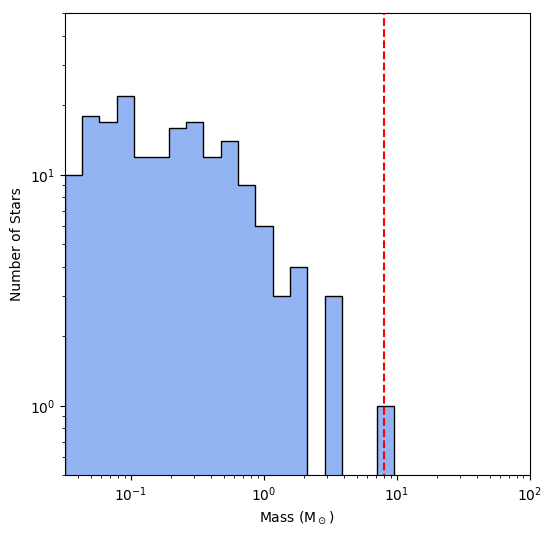

In [6]:
cluster = imf.make_cluster(70)
print(cluster.max())
plt.close()
plt.rcParams.update(plt.rcParamsDefault)
#plt.rcParams.update({'font.size': 16}) #set fontsize
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(6,6))
###
ax.set_ylabel('Number of Stars')
ax.set_xlabel('Mass (M$_\odot$)')

mmin, mmax = min(cluster), max(cluster)
cluster_logbins = np.logspace(np.log10(mmin), np.log10(mmax),20)
h1,l1,p1 = ax.hist(cluster,
                   cluster_logbins, color='cornflowerblue',alpha=0.7, log=True)
h1,l1,p1 = ax.hist(cluster,
                   cluster_logbins, color='k',alpha=1.0,histtype='step', log=True)
ax.plot([8,8],[0,100],color='red',ls='--')
ax.set_xscale("log")
ax.set_ylim(0.5,50)
ax.set_xlim(0,100)
plt.show()

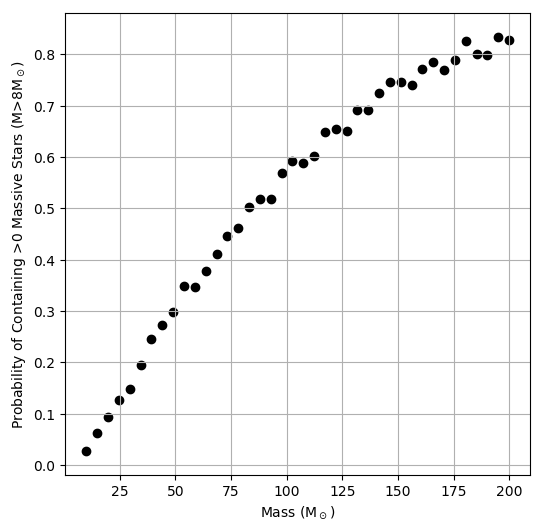

In [13]:
plt.close()
plt.rcParams.update(plt.rcParamsDefault)
#plt.rcParams.update({'font.size': 16}) #set fontsize
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(6,6))
ax.scatter(lim_vals,num_massive_avg,marker='o',color='k')
ax.set_xlabel('Mass (M$_\odot$)')
ax.set_ylabel('Probability of Containing >0 Massive Stars (M>8M$_\odot$)')
ax.grid()
plt.savefig(path+'imf_completeness.pdf')
plt.show()

In [97]:
print lim_vals
print num_massive_avg

[  10.           14.87179487   19.74358974   24.61538462   29.48717949
   34.35897436   39.23076923   44.1025641    48.97435897   53.84615385
   58.71794872   63.58974359   68.46153846   73.33333333   78.20512821
   83.07692308   87.94871795   92.82051282   97.69230769  102.56410256
  107.43589744  112.30769231  117.17948718  122.05128205  126.92307692
  131.79487179  136.66666667  141.53846154  146.41025641  151.28205128
  156.15384615  161.02564103  165.8974359   170.76923077  175.64102564
  180.51282051  185.38461538  190.25641026  195.12820513  200.        ]
[ 0.028  0.06   0.082  0.12   0.159  0.159  0.219  0.273  0.289  0.361
  0.355  0.386  0.416  0.42   0.467  0.486  0.532  0.557  0.56   0.571
  0.621  0.635  0.645  0.645  0.649  0.651  0.712  0.7    0.705  0.752
  0.74   0.756  0.794  0.755  0.795  0.802  0.804  0.808  0.824  0.825]


(32,)
(32,)


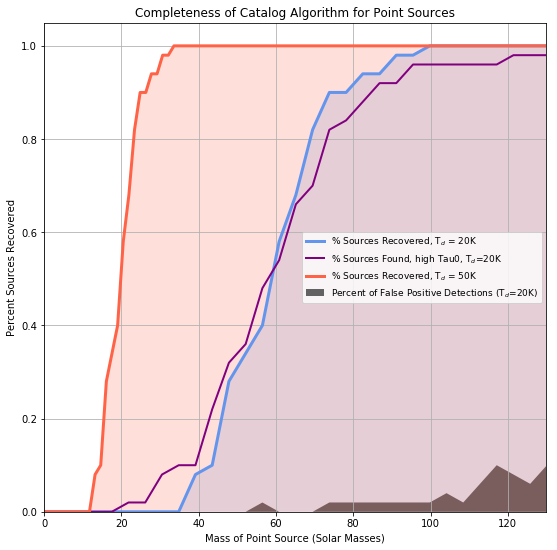

In [8]:
### Plot for mass vs percent found
path='/Users/hph/cmzoom_catalog/catalog_5-28-19/'
### also average runs together
BMAJ    =   9.391762150659E-04
BMIN    =   8.101911677255E-04 
deg2_per_beam = np.pi*BMAJ*BMIN
deg2_per_pix = (1.388888888889E-04)**2

found_avg = np.array([1., 1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    0.98,  0.98,  0.94,  0.94,
                      0.9,   0.9,   0.82,  0.68,  0.58,  0.4,   0.34,  0.28,  0.1,   0.08,  0.,    0.,    0.,
                      0.,    0.,    0.,    0.,    0.,    0.  ])

complete_found = [1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
                  0.9,  0.9,  0.9,  0.9,  0.9,  0.8,  0.8,  0.4,  0.4,  0.3,  0.1,  0.1,  0.2,  0.1,  0., 0.]

complete_found2 = [ 1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
  1.,   1.,   1.,   1.,   0.8,  0.8,  0.5,  0.3,  0.2,  0.2,  0.1,  0.1,  0.1,  0.,   0.,
  0. ]

hightau_avg = np.array([0.98, 0.98,  0.98,  0.98,  0.96,  0.96,  0.96,  0.96,  0.96,  0.96,  0.92,  0.92,  0.88,
                        0.84,  0.82,  0.7,   0.66,  0.54,  0.48,  0.36,  0.32,  0.22,  0.1,   0.1,   0.08,
                        0.02,  0.02,  0.,    0.,    0.,    0.,    0.])

point_fluxes = np.array([0.5, 0.08,        0.07733667,  0.07467333,  0.07201,     0.06934667,  0.06668333,
                         0.06402,     0.06135667,  0.05869333,  0.05603,     0.05336667,  0.05070333,
                         0.04804,     0.04537667,  0.04271333,  0.04005,     0.03738667,  0.03472333,
                         0.03206,     0.02939667,  0.02673333,  0.02407,     0.02140667,  0.01874333,
                         0.01608,     0.01341667,  0.01075333,  0.00809,     0.00542667,  0.00276333,
                         0.0001    ])# added high flux point for ease of plotting, temporary
#fp_avg = np.array([1.4,  1.4,  1.4,  1.2,  0.8,  1.,   2.,   1.2,  0.8,  0.6,  0.2,  0.2,  0.2,  0.2,  0.,
#                     0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
#                     0. ])
fp_avg = np.array([1, 1.,   0.6, 0.8,  1.,   0.6,  0.2,  0.4,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.,
                    0.,   0.,   0.2 , 0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
                    0. ])
fp_avg = fp_avg/10.
#integrated_fluxes = point_fluxes*(deg2_per_pix/deg2_per_beam)

select_found = found_avg#complete_found2
select_fp_avg = fp_avg

integrated_fluxes = point_fluxes
masses = mass_calc_submm(Wave,dustTemp,Kappa,integrated_fluxes,distance)
masses_highT = mass_calc_submm(Wave,50.,Kappa,integrated_fluxes,distance)
print(masses.shape)
print(masses_highT.shape)

plt.close()
mrfig, ax = plt.subplots(nrows=1,ncols=1,figsize=(9,9))
ax.plot(masses, select_found,ls='-',color='cornflowerblue',linewidth=3.0, 
        label='% Sources Recovered, T$_d$ = 20K')
ax.set_xlabel('Mass of Point Source (Solar Masses)')
ax.set_ylabel('Percent Sources Found')
ax.set_title('Completeness of Catalog Algorithm for Point Sources')
ax.set_ylim(0,1.05)
ax.set_xlim(0,130.)
ax.plot(masses, hightau_avg,ls='-',color='purple',linewidth=2.0, label ='% Sources Found, high Tau0, T$_d$=20K' )

ax.grid()
fill = ax.fill_between(masses,select_found, color='cornflowerblue',alpha=0.2,edgecolor='red',linewidth = '0.0')
fill = ax.fill_between(masses,select_fp_avg, color='k',alpha=0.6,edgecolor='k',linewidth = '0.0',
                       label = 'Percent of False Positive Detections (T$_d$=20K)')

ax.plot(masses_highT, select_found,ls='-',color='tomato',linewidth=3.0, 
        label='% Sources Recovered, T$_d$ = 50K')
plt.xlabel('Mass of Point Source (Solar Masses)')
ax.set_ylabel('Percent Sources Recovered')
plt.title('Completeness of Catalog Algorithm for Point Sources')
ax.grid()
fill = ax.fill_between(masses_highT,select_found, color='tomato',alpha=0.2,edgecolor='red',linewidth = '0.0')
#fill = ax.fill_between(masses_highT,select_fp_avg, color='k',alpha=0.2,edgecolor='k',linewidth = '0.0')
plt.legend(loc='center right',fontsize=9)
ax.grid()
#####################################################################
plt.savefig(path+'simobs_percent_5-28-19.pdf')
plt.show()

(30,)
(30,)


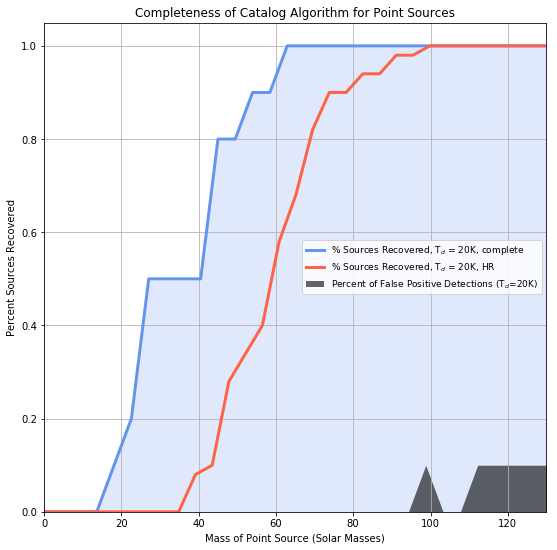

In [24]:
### Plot for mass vs percent found
path='/Users/hph/cmzoom_catalog/catalog_5-28-19/'
### also average runs together
BMAJ    =   9.391762150659E-04
BMIN    =   8.101911677255E-04 
deg2_per_beam = np.pi*BMAJ*BMIN
deg2_per_pix = (1.388888888889E-04)**2

desiredPeakValue = .08#4.*10**7
max_init_Peak = round(desiredPeakValue,3)
desired_Min_Peak = 0.0001
min_Peak = round(desired_Min_Peak,4)
step_array = np.linspace(max_init_Peak, min_Peak,30)

found_avg = np.array([1., 1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    0.98,  0.98,  0.94,  0.94,
                      0.9,   0.9,   0.82,  0.68,  0.58,  0.4,   0.34,  0.28,  0.1,   0.08,  0.,    0.,    0.,
                      0.,    0.,    0.,    0.,    0.,    0.  ])

complete_found = [1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
                  0.9,  0.9,  0.9,  0.9,  0.9,  0.8,  0.8,  0.4,  0.4,  0.3,  0.1,  0.1,  0.2,  0.1,  0., 0.]

complete_found2 = [ 1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
  1.,   1.,   1.,   1.,   0.8,  0.8,  0.5,  0.3,  0.2,  0.2,  0.1,  0.1,  0.1,  0.,   0.,
  0. ]

complete_found3 = np.array([ 1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   0.9,  0.9,  1.,   0.9,  0.8,
  0.7,  0.3,  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0. ])

complete_found4 = np.array([ 1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   0.9,
  0.7,  0.6,  0.5,  0.5,  0.4,  0.4,  0.4,  0.3,  0.3,  0.2,  0.,   0.,   0.,   0.,   0. ])

complete_found5 = np.array([1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
                            1.,   0.9,  0.9,  0.8,  0.8,  0.5,  0.5, 0.5,  0.5,  0.2,  0.1,  0.,   0.,   0.,   0. ])

hightau_avg = np.array([0.98, 0.98,  0.98,  0.98,  0.96,  0.96,  0.96,  0.96,  0.96,  0.96,  0.92,  0.92,  0.88,
                        0.84,  0.82,  0.7,   0.66,  0.54,  0.48,  0.36,  0.32,  0.22,  0.1,   0.1,   0.08,
                        0.02,  0.02,  0.,    0.,    0.,    0.,    0.])

point_fluxes = np.array([0.5, 0.08,        0.07733667,  0.07467333,  0.07201,     0.06934667,  0.06668333,
                         0.06402,     0.06135667,  0.05869333,  0.05603,     0.05336667,  0.05070333,
                         0.04804,     0.04537667,  0.04271333,  0.04005,     0.03738667,  0.03472333,
                         0.03206,     0.02939667,  0.02673333,  0.02407,     0.02140667,  0.01874333,
                         0.01608,     0.01341667,  0.01075333,  0.00809,     0.00542667,  0.00276333,
                         0.0001    ])# added high flux point for ease of plotting, temporary
point_fluxes2 = np.array([0.06,        0.05800333,  0.05600667,  0.05401,     0.05201333,  0.05001667,
                          0.04802,     0.04602333,  0.04402667,  0.04203,     0.04003333,  0.03803667,
                          0.03604,     0.03404333,  0.03204667,  0.03005,     0.02805333])

#fp_avg = np.array([1.4,  1.4,  1.4,  1.2,  0.8,  1.,   2.,   1.2,  0.8,  0.6,  0.2,  0.2,  0.2,  0.2,  0.,
#                     0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
#                     0. ])
fp_avg = np.array([1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
                   0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
fp_avg = fp_avg/10.
#integrated_fluxes = point_fluxes*(deg2_per_pix/deg2_per_beam)

select_found = complete_found5
select_fp_avg = fp_avg
hr_found = found_avg
hr_masses = mass_calc_submm(Wave,dustTemp,Kappa,point_fluxes,distance)

integrated_fluxes = step_array
masses = mass_calc_submm(Wave,dustTemp,Kappa,integrated_fluxes,distance)
masses_highT = mass_calc_submm(Wave,50.,Kappa,integrated_fluxes,distance)
print(masses.shape)
print(masses_highT.shape)

plt.close()
mrfig, ax = plt.subplots(nrows=1,ncols=1,figsize=(9,9))
ax.plot(masses, select_found,ls='-',color='cornflowerblue',linewidth=3.0, 
        label='% Sources Recovered, T$_d$ = 20K, complete')
ax.plot(hr_masses, hr_found,ls='-',color='tomato',linewidth=3.0, 
        label='% Sources Recovered, T$_d$ = 20K, HR')
ax.set_xlabel('Mass of Point Source (Solar Masses)')
ax.set_ylabel('Percent Sources Found')
ax.set_title('Completeness of Catalog Algorithm for Point Sources')
ax.set_ylim(0,1.05)
ax.set_xlim(0,130.)
#ax.plot(masses, hightau_avg,ls='-',color='purple',linewidth=2.0, label ='% Sources Found, high Tau0, T$_d$=20K' )

ax.grid()
fill = ax.fill_between(masses,select_found, color='cornflowerblue',alpha=0.2,edgecolor='red',linewidth = '0.0')
fill = ax.fill_between(masses,select_fp_avg, color='k',alpha=0.6,edgecolor='k',linewidth = '0.0',
                       label = 'Percent of False Positive Detections (T$_d$=20K)')

#ax.plot(masses_highT, select_found,ls='-',color='tomato',linewidth=3.0, 
#        label='% Sources Recovered, T$_d$ = 50K')
plt.xlabel('Mass of Point Source (Solar Masses)')
ax.set_ylabel('Percent Sources Recovered')
plt.title('Completeness of Catalog Algorithm for Point Sources')
ax.grid()
#fill = ax.fill_between(masses_highT,select_found, color='tomato',alpha=0.2,edgecolor='red',linewidth = '0.0')
#fill = ax.fill_between(masses_highT,select_fp_avg, color='k',alpha=0.2,edgecolor='k',linewidth = '0.0')
plt.legend(loc='center right',fontsize=9)
ax.grid()
#####################################################################
#plt.savefig(path+'simobs_percent_5-28-19.pdf')
plt.show()

In [14]:
print(masses.shape)
print(select_found.shape)

(30,)
(32,)
